# MNIST

Training of a small MLP on MNIST with MSE loss

[Original resource here](https://github.com/pytorch/examples/blob/master/mnist/main.py)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [4]:
# Training settings
batch_size=64
epochs=1
lr=0.01
momentum=0.0
seed=1101

din=784
dout=10
dh=50

nbatches=30 # n.batches to evaluate statistics

In [5]:
class Net(nn.Module):
    def __init__(self,din=784, dh=30, dout=10):
        super(Net, self).__init__()
        
        self.lin1 = nn.Linear(din, dh)
        self.lin2 = nn.Linear(dh, dout)
    
    def forward(self, x):    
        x = torch.sigmoid(self.lin1(x)) 
        return self.lin2(x)

In [28]:
#onehot = torch.FloatTensor(1, 10).zero_().to(device) # *

#onehot.scatter_(1, 64, 1) # *

TypeError: scatter_() received an invalid combination of arguments - got (int, int, int), but expected one of:
 * (int dim, Tensor index, Tensor src)
      didn't match because some of the arguments have invalid types: ([32;1mint[0m, [31;1mint[0m, [31;1mint[0m)
 * (int dim, Tensor index, Number value)
      didn't match because some of the arguments have invalid types: ([32;1mint[0m, [31;1mint[0m, [31;1mint[0m)


### MSE loss

Lines which are specific to MSE loss are marked with *

In [12]:
criterion = nn.MSELoss() # *

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    

    for batch_idx, (data, target) in enumerate(train_loader):
        
        
        data, target = data.to(device), target.to(device)
        
        print(data.shape)
        print(target.shape)
            
        data = data.view(-1,784) # *
        
        target = target.view(-1,1) # *
        onehot = torch.FloatTensor(data.shape[0], 10).zero_().to(device) # *
        onehot.scatter_(1, target, 1) # *
        target = onehot # *
    
        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

In [13]:
def stats(model, device, loader, nsamples=batch_size*nbatches):
    
    model.eval() 
    
    loss = 0
    correct = 0
    count = 0
    
    origin = 'train' if loader.dataset.train else 'test'
    
    with torch.no_grad():
        
        for data, target in loader:
            
            count += data.shape[0]
                
            if count > nsamples:
                break
                
            data, target = data.to(device), target.to(device)     
            
            
            data = data.view(-1,784) # *
            target = target.view(-1,1) # *
            onehot = torch.FloatTensor(data.shape[0], 10).zero_().to(device) # *
            onehot.scatter_(1, target, 1) # *
            
    
            output = model(data)
            
            loss += criterion(output, onehot).item()
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    loss /= count  
    acc = 100. * correct / count
    

    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(origin,
        loss, correct, count,
        acc ) )
    
    
    return loss,acc

In [14]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [15]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)

In [16]:
model = Net(din,dh,dout).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [18]:
?criterion

In [17]:
train_stats = []
test_stats = []

for epoch in range(1, epochs + 1):
    
    train(model, device, train_loader, optimizer, epoch)
    
    train_stats.append(stats(model, device, train_loader))
    test_stats.append(stats(model, device, test_loader))
    
train_stats = np.array(train_stats)
test_stats = np.array(test_stats)

torch.Size([64, 1, 28, 28])
torch.Size([64])


RuntimeError: size mismatch, m1: [1792 x 28], m2: [784 x 50] at /opt/conda/conda-bld/pytorch-cpu_1549632688322/work/aten/src/TH/generic/THTensorMath.cpp:940

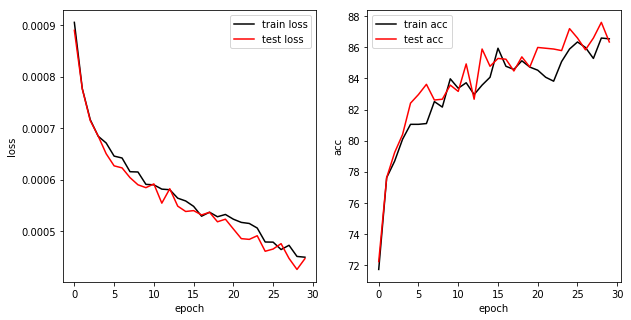

In [14]:
fig=plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(train_stats[:,0],'-k',label='train loss')
plt.plot(test_stats[:,0],'-r',label='test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(122)
plt.plot(train_stats[:,1],'-k',label='train acc')
plt.plot(test_stats[:,1],'-r',label='test acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()


plt.show()

# Exercises

Experiment with this problem changing:

- size of hidden layer
- adding another hidden layer
- store accuracy and loss on training and test set

Go to the documentation and see how to save/load models